In [1]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad

# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn.datasets as skdatasets

from celluloid import Camera
import scienceplots
from IPython.display import Image

np.random.seed(0)
plt.style.use(['science','no-latex'])

## Training Dataset

Let's import the breast cancer dataset. The logistic regression will perform binary classification using the mean perimeter and mean radius of the tumor.

Text(0.5, 1.0, 'Breast Cancer Dataset')

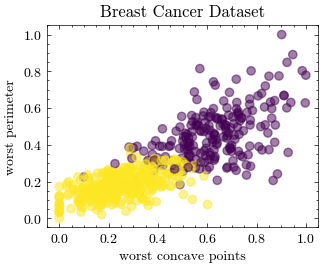

In [2]:
dataset = skdatasets.load_breast_cancer()

features_used = [-3, -8]
X = dataset.data[:, features_used]
feature_names = dataset.feature_names[features_used]

# min-max normalize the features along the columns
X_min_vals = X.min(axis=0)
X_max_vals = X.max(axis=0)
X = (X - X_min_vals) / (X_max_vals - X_min_vals)

Y = dataset.target
target_names = dataset.target_names

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(X[:, 0], X[:, 1], c=Y, alpha=0.5)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_title("Breast Cancer Dataset")

## Activation Function

Recall that the output of the perceptron was the dot product between the weight vector $w$ and the input vector $x$ plus a constant bias term $b$

Perceptron: $y=w^Tx + b$

Activation functions are applied after the computation.

### Sigmoid Function

In order to do binary classification, we would like to limit the value of the output to be in the range (0, 1) and get a value to represent the probability of the output being assigned to either class. The sigmoid function is perfect for this

$
\sigma(z) = \frac{1}{1+e^-z}
$

In [3]:
sigmoid = lambda x: 1/(1+np.exp(-x))

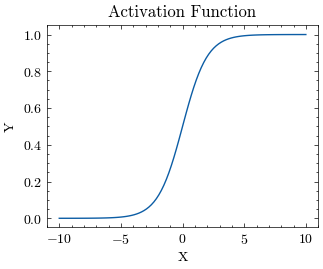

In [4]:
def plot(fx, x_min, x_max, points=100, title=""):

    x = np.linspace(x_min, x_max, points)
    y = fx(x)

    fig, axes = plt.subplots()
    axes.plot(x, y)
    axes.set_xlabel("X")
    axes.set_ylabel("Y")
    axes.set_title("Activation Function")

    fig.show()

x_min = -10
x_max = 10
points = 100
plot(sigmoid, x_min, x_max, points)

## Gradient of Sigmoid Function

Gradient Descent will be used later to find the optimal weight values. As a result, let's calculate the gradient of the sigmoid function.

$
\begin{align*}
\sigma^\prime
&= \frac{\partial}{\partial z} \sigma(z) \\
&= \frac{\partial}{\partial z} (\frac{1}{1+e^{-z}}) \\
&= \frac{\partial}{\partial z} (1+e^{-z})^{-1}) \\
&= (-1)(1+e^{-z})^{-2}\frac{\partial}{\partial z}(1+e^{-z}) \\
&= (-1)(1+e^{-z})^{-2}(e^{-z})\frac{\partial}{\partial z}(-z) \\
&= (-1)(1+e^{-z})^{-2}(e^{-z})(-1) \\
&= \frac{e^{-z}}{(1+e^{-z})^{2}}
\end{align*}
$

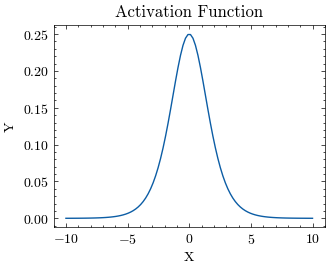

In [5]:
sigmoid_prime = lambda x: np.exp(-x) / np.power((1 + np.exp(-x)), 2)
plot(sigmoid_prime, x_min, x_max, points)

## Autograd
Alternatively, you can use autograd to differentiate a numpy function. Pytorch and JAX also implement autograd.

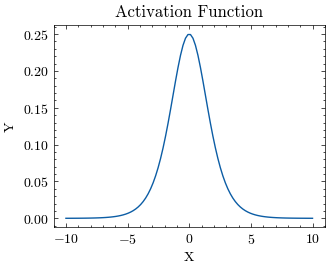

In [6]:
# grad() differentiates scalar inputs
sigmoid_prime_grad = grad(sigmoid)
# egrad() differentiates vectorized inputs
sigmoid_prime_egrad = egrad(sigmoid)

x = np.linspace(x_min, x_max, points)
assert sigmoid_prime_grad(x[0]) == sigmoid_prime(x[0])
assert np.allclose(sigmoid_prime_egrad(x), sigmoid_prime(x))

plot(sigmoid_prime_egrad, x_min, x_max, points)

## Loss Function

The binary cross entropy loss function will be used for logistic regression. This loss function is derived from the definition of maximum likelihood estimation.

$
\begin{align*}
L(\hat y) &= -\frac{1}{n} \sum_{i=1}^{n} [y_i \ln(\hat y_i) + (1-y_i) \ln(1 - \hat y_i)]
\end{align*}
$

In [7]:
def bce(y_true, y_pred):
    return -np.sum(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

## Loss Function Gradient


Recall that $\hat y = \frac{1}{1+e^-(\vec{w} \cdot \vec{x} + b)}$


$
\begin{align*}
L(\vec{w}, b) = -\frac{1}{n} \sum_{i=1}^{n} [y_i \ln(\frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}}) + (1-y_i) \ln(1 - \frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}})]
\end{align*}
$

Loss function with respect to $W$
 
$
\begin{align*}
\nabla_{W} [L(\vec{w}, b)] &= \nabla_{W} [-\sum_{i=1}^{n} y_i \ln(\frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}}) + (1-y_i) \ln(1 - \frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}})] \\
&= \frac{1}{n} \sum_{i=1}^{n} [x_i (\hat y_i - y_i)]
\end{align*}
$

In [8]:
def bce_dw(x, y_true, y_pred):
    return np.mean(x*(y_pred-y_true))

Loss function with respect to $b$

$
\begin{align*}
\frac{\partial}{\partial b}  [L(\vec{w}, b)] &= \frac{\partial}{\partial b} [-\sum_{i=1}^{n} y_i \ln(\frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}}) + (1-y_i) \ln(1 - \frac{1}{1+e^{-(\vec{w} \cdot \vec{x_i} + b)}})] \\
&= \frac{1}{n} \sum_{i=1}^{n} (\hat y_i - y_i)
\end{align*}
$

In [9]:
def bce_db(y_true, y_pred):
    return np.mean(y_pred-y_true)

## Gradient Descent

With the binary cross entropy functions with respect to $\vec{w}$ and $b$, the gradient descent equations are:

Gradient Descent for weights $\vec{w}$

$
\begin{align*}
\vec{w} &= \vec{w} - \eta \nabla_{W} [L(\vec{w}, b)] \\
&= \vec{w} - \eta [\frac{1}{n} \sum_{i=1}^{n} [x_i (\hat y_i - y_i)]]
\end{align*}
$

Gradient Descent for bias $b$

$
\begin{align*}
b &= b - \eta \frac{\partial}{\partial b} [L(\vec{w}, b)] \\
&= b - \eta [\frac{1}{n} \sum_{i=1}^{n} (\hat y_i - y_i)]
\end{align*}
$

In [10]:
def gradient_descent(weights, x, bias, y_true, y_pred, learning_rate):
    weights = weights - learning_rate * bce_dw(x, y_true, y_pred)
    bias = bias - learning_rate * bce_db(y_true, y_pred)

    return weights, bias

## Training the model

In [11]:
def create_plots():
    fig, ax = plt.subplots(1, 3, figsize=(16 / 9.0 * 4, 4 * 1))
    fig.suptitle("Logistic Regression")

    ax[0].set_xlabel("Epoch", fontweight="normal")
    ax[0].set_ylabel("Error", fontweight="normal")
    ax[0].set_title("Binary Cross Entropy Error")

    ax[1].axis("off")
    ax[2].axis("off")

    ax[2] = fig.add_subplot(1, 2, 2, projection="3d")
    ax[2].set_xlabel("X")
    ax[2].set_ylabel("Y")
    ax[2].set_zlabel("Z")
    ax[2].set_title("Prediction Probabilities")
    ax[2].view_init(20, -35)

    camera = Camera(fig)
    return ax[0], ax[2], camera

In [12]:
def fit(
    w0, b0, features, labels, dims, epochs, learning_rate, optimizer, output_filename
):
    mse_idx = np.arange(1, epochs + 1)
    errors = np.full(epochs, -1)
    ax0, ax1, camera = create_plots()

    points = np.linspace(-1, 1, dims)
    surface_points = np.column_stack((points, points))

    weights = w0
    bias = b0

    for idx in range(epochs):
        error = 0
        predictions = np.array([])

        # fit the model on the training data
        for x, y in zip(features, labels):
            output = sigmoid(np.dot(weights, x) + bias)

            predictions = np.append(predictions, output)

            # Store Error
            error += bce(y, output)

            # Gradient Descent
            weights, bias = optimizer(weights, x, bias, y, output, learning_rate)

        # Visualization
        if (
            idx < 5
            or (idx < 15 and idx % 5 == 0)
            or (idx <= 50 and idx % 25 == 0)
            or (idx <= 1000 and idx % 100 == 0)
            or idx % 250 == 0
        ):

            print(f"epoch: {idx:>5}, BCA: {round(error, 2)}")

            # Plot BCE
            errors[idx] = error
            visible_mse = errors != -1
            ax0.plot(
                mse_idx[visible_mse][: idx + 1],
                errors[visible_mse][: idx + 1],
                color="red",
                alpha=0.5,
            )
            X[:, 0], X[:, 1]

            # Plot Logistic Regression Predictions
            # Ground truth and training data
            ground_truth_legend = ax1.scatter(
                features[:, 0], features[:, 1], labels, color="red", alpha=0.5, label="Ground Truth"
            )
            # Logistic Regression Predictions
            predictions_legend = ax1.scatter(
                features[:, 0],
                features[:, 1],
                predictions,
                color="blue",
                alpha=0.2,
                label="Prediction",
            )
            ax1.legend(
                (ground_truth_legend, predictions_legend),
                ("Ground Truth", "Predictions"),
                loc="upper left",
            )

            camera.snap()

    animation = camera.animate()
    animation.save(output_filename, writer="pillow")
    plt.close()

In [13]:
epochs = 4001
learning_rate = 0.0005
dims = 10

w0 = np.random.rand(X[0].shape[0])
b0 = np.random.rand()

output_filename = "logistic_regression.gif"
fit(w0, b0, X, Y, dims, epochs, learning_rate, gradient_descent, output_filename)

epoch:     0, BCA: 444.23
epoch:     1, BCA: 438.52
epoch:     2, BCA: 433.32
epoch:     3, BCA: 428.58
epoch:     4, BCA: 424.25
epoch:     5, BCA: 420.28
epoch:    10, BCA: 404.5
epoch:    25, BCA: 375.53
epoch:    50, BCA: 341.83
epoch:   100, BCA: 291.99
epoch:   200, BCA: 231.95
epoch:   250, BCA: 212.92
epoch:   300, BCA: 198.1
epoch:   400, BCA: 176.56
epoch:   500, BCA: 161.66
epoch:   600, BCA: 150.72
epoch:   700, BCA: 142.34
epoch:   750, BCA: 138.84
epoch:   800, BCA: 135.71
epoch:   900, BCA: 130.32
epoch:  1000, BCA: 125.86
epoch:  1250, BCA: 117.46
epoch:  1500, BCA: 111.57
epoch:  1750, BCA: 107.21
epoch:  2000, BCA: 103.85
epoch:  2250, BCA: 101.19
epoch:  2500, BCA: 99.03
epoch:  2750, BCA: 97.24
epoch:  3000, BCA: 95.75
epoch:  3250, BCA: 94.48
epoch:  3500, BCA: 93.39
epoch:  3750, BCA: 92.44
epoch:  4000, BCA: 91.61


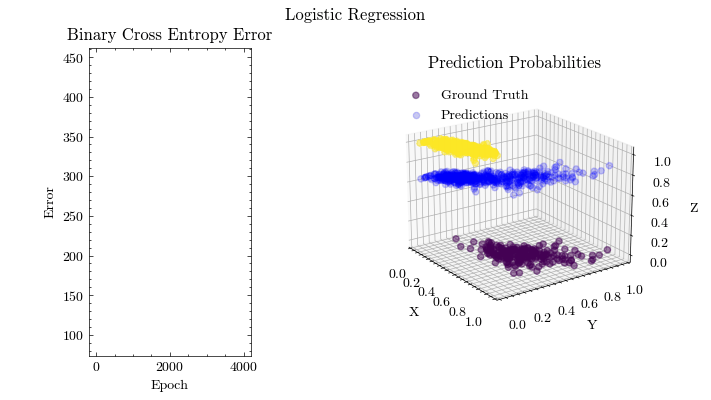

In [14]:
Image(filename=output_filename)